In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt

from dotenv import load_dotenv
load_dotenv('../../azimuth.env')
import os
import sys
sys.path.append(os.environ['PATH_ROOT'])
print('PATH_ROOT:', os.environ['PATH_ROOT'], ' has been added to sys.path')

# Set the style for publication-quality plots
plt.style.use('seaborn-v0_8-paper')  # Clean, professional style
plt.rcParams.update({
    'font.family': 'serif',  # Use serif fonts
    'font.serif': ['Arial'],  # Use Times New Roman
    'font.size': 8,         # Readable font size
    'axes.linewidth': 1.0,   # Thicker axes lines
    'axes.labelsize': 8,    # Size for axis labels
    'xtick.labelsize': 8,    # Size for x-tick labels
    'ytick.labelsize': 8,    # Size for y-tick labels
})


PATH_ROOT: /Users/thinhhoang/Documents/project-azimuth/  has been added to sys.path


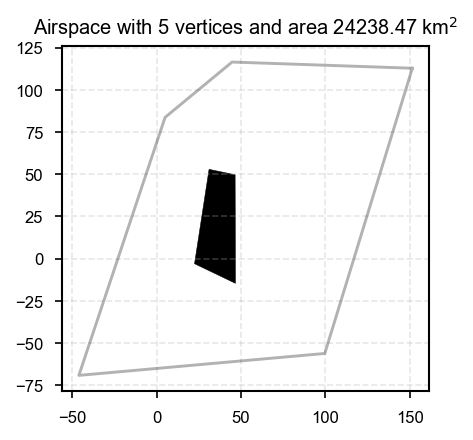

In [2]:
# Testing airspace radius sampling
import MARTINI.airspace.randomize_airspace as randomize_airspace
import MARTINI.airspace.geo as geo
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

# Generate a random airspace
airspace, area = randomize_airspace.generate_unit_polygon(5, 150)
# Get airspace centroid
centroid = geo.compute_polygon_centroid(airspace)
# Generate an obstacle
obstacle, area_obstacle = randomize_airspace.generate_unit_polygon(4, 35)
# Set the obstacle centroid to the airspace centroid
obstacle[:, 0] += centroid[0]
obstacle[:, 1] += centroid[1]

from ALPHA.obstacle.obstacle import Obstacle

obstacle_obj = Obstacle()
obstacle_obj.add_polygon(obstacle)

# Visualize the airspace
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.plot(np.append(airspace[:, 0], airspace[0, 0]), 
             np.append(airspace[:, 1], airspace[0, 1]), 
             alpha=0.3, color='black')

# Plot the obstacle
ax.fill(np.append(obstacle[:, 0], obstacle[0, 0]), 
             np.append(obstacle[:, 1], obstacle[0, 1]), 
             color='black')
ax.set_title(f'Airspace with {len(airspace)} vertices and area {area:.2f} km$^2$')
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

# Building a search tree

In [124]:
# Create a flight plan
from MARTINI.aircraft.flight_plan import FlightPlan
flight_plan = FlightPlan(waypoints=[airspace[3] * 1000, (0, 0), airspace[0] * 1000], altitudes=[10000, 10000, 10000], speeds=[250, 250, 250],
                         entry_time=0, entry_psi=0)
print(flight_plan)

Flight plan with 3 waypoints
* Waypoint 0: [-46004.65971903 -69208.99516734]
Altitude: 10000
Speed: 250
* Waypoint 1: [0. 0.]
Altitude: 10000
Speed: 250
* Waypoint 2: [151507.49092251 112721.89529166]
Altitude: 10000
Speed: 250


In [125]:
import ALPHA.treesearch.tree as tree

# Create a tree with flight plan as the state
my_tree = tree.Tree(root_state=flight_plan)


In [126]:
my_tree.evaluate_all_nodes(obstacle_obj, airspace)
print('Inherent cost of root:', my_tree.root.inherent_cost)

Inherent cost of root: 3114.473323816716


In [127]:
# Get actions for the root node
segment_idx, actions = my_tree.root.get_actions(obstacle_obj)

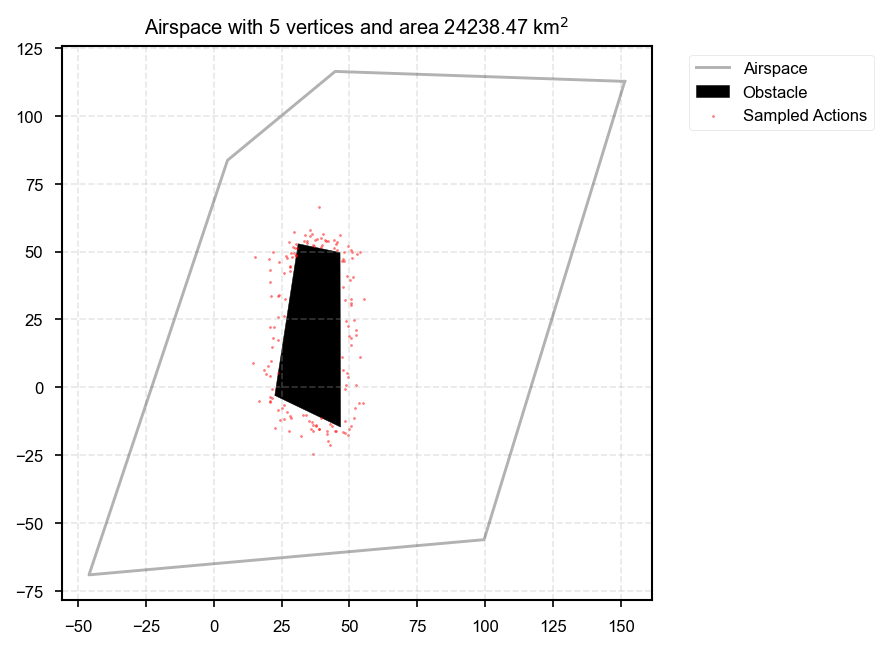

In [128]:
# Scatter plot the action
# Testing airspace radius sampling
import MARTINI.airspace.randomize_airspace as randomize_airspace
import MARTINI.airspace.geo as geo
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

# Visualize the airspace
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.plot(np.append(airspace[:, 0], airspace[0, 0]), 
             np.append(airspace[:, 1], airspace[0, 1]), 
             alpha=0.3, color='black')

# Plot the obstacle
ax.fill(np.append(obstacle[:, 0], obstacle[0, 0]), 
             np.append(obstacle[:, 1], obstacle[0, 1]), 
             color='black')

# Scatter plot the action
ax.scatter(actions[:, 0], actions[:, 1], color='red', s=1, alpha=0.5)
ax.set_title(f'Airspace with {len(airspace)} vertices and area {area:.2f} km$^2$')
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_aspect('equal')

# Add legend
ax.plot([], [], color='black', alpha=0.3, label='Airspace')
ax.fill([], [], color='black', label='Obstacle') 
ax.scatter([], [], color='red', s=1, alpha=0.5, label='Sampled Actions')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()

In [129]:
import copy

# Randomizing the action
for i in range(100):
    # Uniformly sample a point in the actions
    random_idx = np.random.randint(0, len(actions))
    # print(f'Sampled action {i}:', actions[random_idx])
    # Add to the search tree
    # New state is the flight plan with the new waypoint
    flight_plan_new = copy.deepcopy(my_tree.root.state)
    # The waypoint to add is the action:
    wp_to_add = actions[random_idx] * 1000 # convert to meters
    # Insert the new waypoint at position segment_idx + 1 (segment_idx is the index of the affected segment, so the node should be located after that segment)
    flight_plan_new.waypoints = np.insert(flight_plan_new.waypoints, segment_idx + 1, wp_to_add, axis=0)
    # Insert the new altitude and speed at position segment_idx
    flight_plan_new.altitudes = np.insert(flight_plan_new.altitudes, segment_idx + 1, flight_plan_new.altitudes[segment_idx], axis=0)
    flight_plan_new.speeds = np.insert(flight_plan_new.speeds, segment_idx + 1, flight_plan_new.speeds[segment_idx], axis=0)
    if not flight_plan_new.validate_no_turnaround():
        print('Invalid flight plan (turn > 180 degrees)')
        continue
    action_hash = '/'.join([str(segment_idx), str(wp_to_add)])
    my_tree.root.add_child(action_hash, flight_plan_new, policy_category='obstacle')


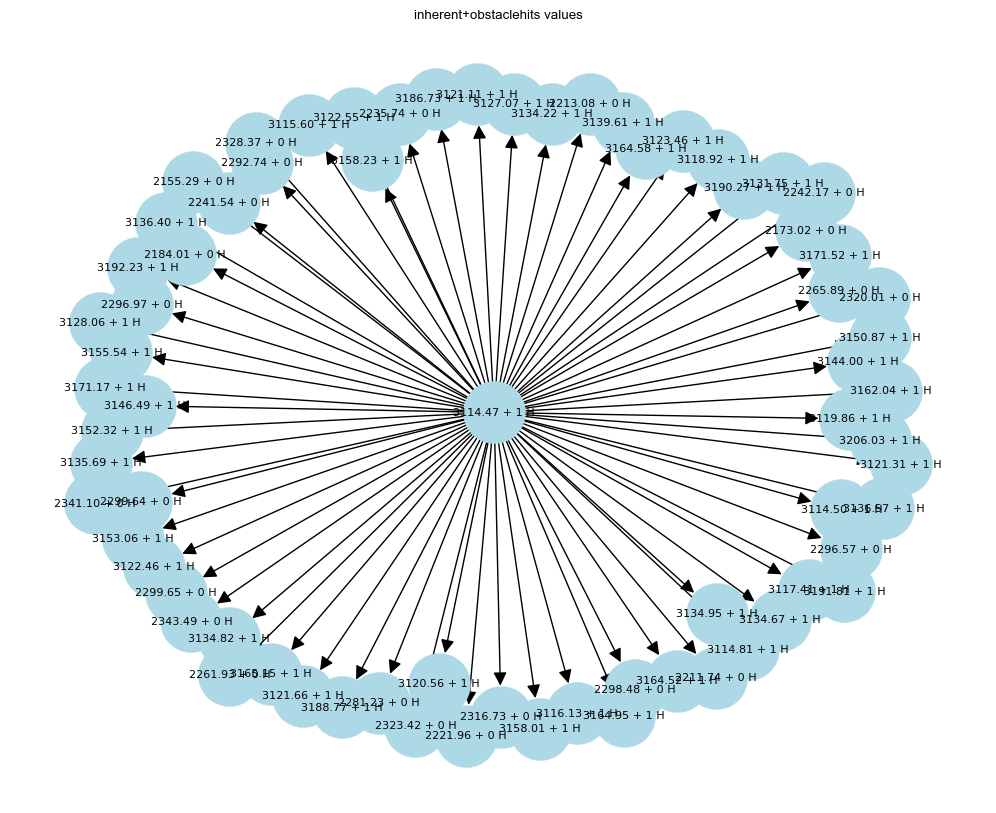

Best value: 2155.290234416769


In [130]:
# Re-evaluate the tree
my_tree.evaluate_all_nodes(obstacle_obj, airspace)
my_tree.plot(value_type='inherent+obstaclehits')

print('Best value:', my_tree.root.best_value)

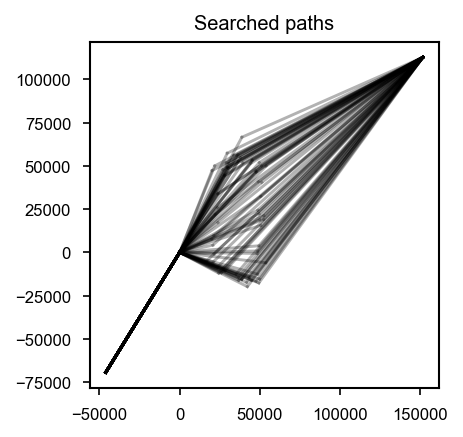

In [131]:
plt.figure(figsize=(3, 3), dpi=150)

# Iterate through children and get their states
for action, child_node in my_tree.root.children.items():
    flight_plan = child_node.state
    # print(f"\nAction: {action}")
    # print(f"Number of waypoints: {len(flight_plan)}")
    # print(f"Waypoints: {flight_plan.waypoints}")

    for i in range(len(flight_plan.waypoints) - 1):
        plt.plot([flight_plan.waypoints[i][0], flight_plan.waypoints[i+1][0]], [flight_plan.waypoints[i][1], flight_plan.waypoints[i+1][1]], color='black', alpha=0.3)

plt.title('Searched paths')
plt.show()